# Plot trends in OLR, ASR, and AIRS spectral OLR by month

In [100]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features
    )

from collections import deque
%matplotlib inline

## Load CERES-EBAF data

In [4]:
ceres_dir = '/glade/work/jonahshaw/obs/CERES'
ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc'

In [5]:
ceres_ds = xr.open_dataset('%s/%s' % (ceres_dir,ceres_file))

#### Add an absorbed solar radiation variable

In [164]:
ceres_ds['ASR'] = ceres_ds['solar_mon'] - ceres_ds['toa_sw_all_mon']

### Plot month OLRs for the Arctic Ocean (70-90N)

If I want to use a better mask, should I use the LANDFRAC variable in CESM or is there something better?

In [47]:
olr_wgt = add_weights(ceres_ds['toa_lw_all_mon'])

In [48]:
month_groups = olr_wgt.groupby('time.month')

Compute monthly OLRs (inefficient, could vectorize)

In [84]:
olr_temp = []
labels = []

for label,month in month_groups:
    arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat<70)
    
    olr_temp.append(arc_ocn_avg)
    labels.append(label)
#     break
olr_temp = np.array(olr_temp)

#### Sanity plot looks good

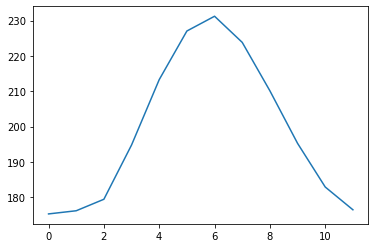

In [85]:
plt.plot(olr_temp)

### Plot a monthly trend

In [168]:
# average over the Arctic Ocean spatially, but not temporally
spat_avg = masked_average(olr_wgt,weights=olr_wgt['cell_weight'],mask=olr_wgt.lat<70,dim=['lat','lon'])

#### All months sanity plot looks good

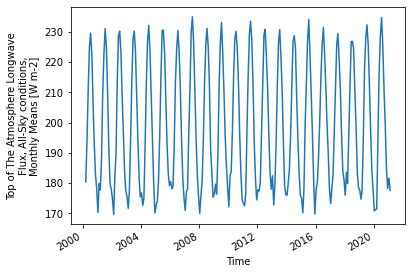

In [169]:
spat_avg.plot()

In [171]:
# For making month labels
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

Text(0.5, 0.98, 'CERES OLR (70-90N)')

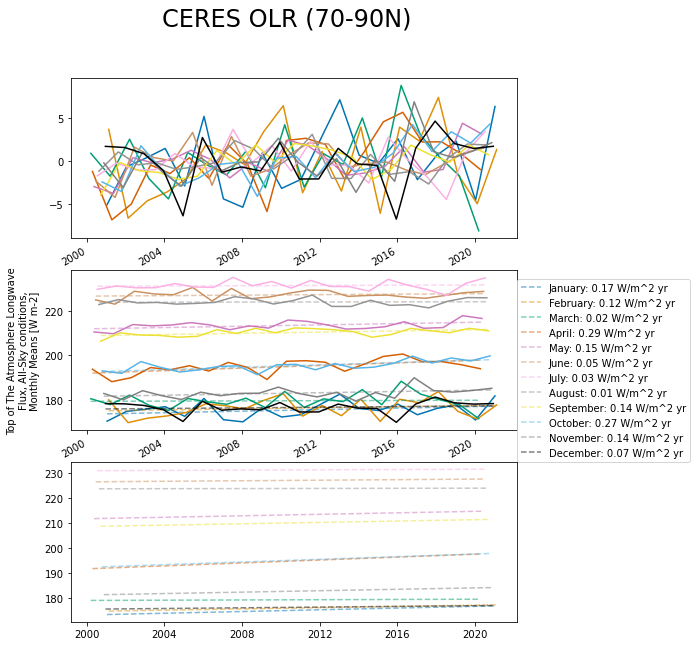

In [178]:
fig,axes = plt.subplots(3,1,figsize=(8,10))

lines=[]
mon_groups = spat_avg.groupby('time.month')

for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
    mon_norm = mon - mon.mean() # normalize to the average

    out = regress_1d(mon['time.year'],mon)
    line = (mon['time.year'].values*out.coef_ + out.intercept_).squeeze()
    label = '%s: %.2f W/m^2 yr' % (mon_dict[str(ind)],out.coef_)
    
    
    mon_norm.plot(label=label,ax=axes[0],color=color)
    out = mon.plot(label=label,ax=axes[1],color=color)
    
    axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
    axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)    
    
    lines.append(out)
    
axes[2].legend(loc=[1,1])

fig.suptitle('CERES OLR (70-90N)',fontsize=24)

### Package and repeat for other CERES variables

In [179]:
def plot_trends(ds,title):
    '''
    Create the above plot with a single command.
    
    '''
    
    var_wgt = add_weights(ds)
    # average over the Arctic Ocean spatially, but not temporally
    spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.lat<70,dim=['lat','lon'])
    
    fig,axes = plt.subplots(3,1,figsize=(8,10))

    lines=[]
    mon_groups = spat_avg.groupby('time.month')

    for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
        mon_norm = mon - mon.mean() # normalize to the average

        out = regress_1d(mon['time.year'],mon)
        line = (mon['time.year'].values*out.coef_ + out.intercept_).squeeze()
        label = '%s: %.2f W/m^2 yr' % (mon_dict[str(ind)],out.coef_)


        mon_norm.plot(label=label,ax=axes[0],color=color)
        out = mon.plot(label=label,ax=axes[1],color=color)

        axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
        axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)

        lines.append(out)

    axes[2].legend(loc=[1,1])

    fig.suptitle(title,fontsize=24)
    

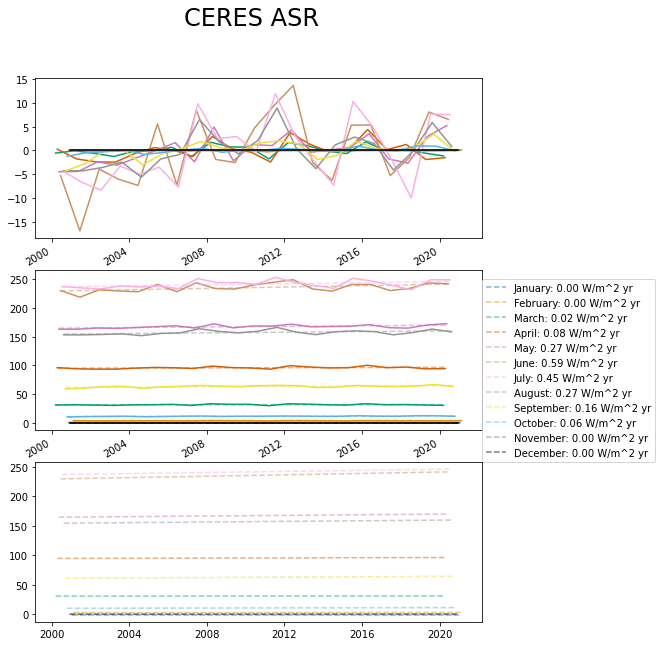

In [182]:
plot_trends(ceres_ds['ASR'],'CERES ASR')

In [57]:
arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat>70)

In [58]:
arc_ocn_avg

<xarray.DataArray ()>
array(239.40678, dtype=float32)
Attributes:
    long_name:      Top of The Atmosphere Longwave Flux, All-Sky conditions, ...
    standard_name:  TOA Longwave Flux - All-Sky
    CF_name:        toa_outgoing_longwave_flux
    comment:        none
    units:          W m-2
    valid_min:            0.00000
    valid_max:            400.000

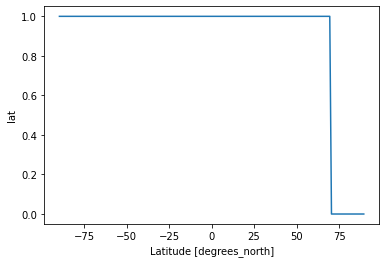

In [55]:
(month.lat<70).plot()

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


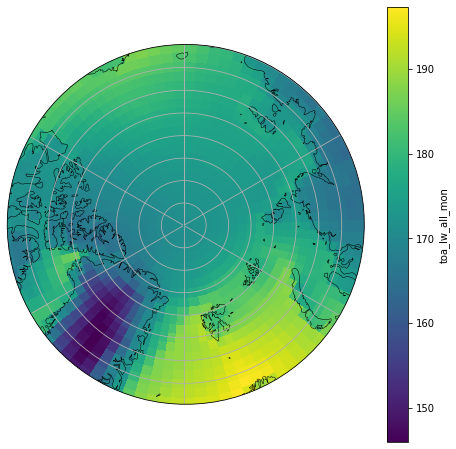

In [43]:
fig,ax = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[8,8])

polarCentral_set_latlim([70,90], ax)

month.where(month.lat>70).mean('time').plot(ax=ax, transform=ccrs.PlateCarree())

add_map_features(ax)

In [21]:
type(group)

xarray.core.dataarray.DataArray

In [33]:
ax.plot(month.where(month.lat>70).mean('time'),projection=ccrs.NorthPolarStereo())

AttributeError: 'Line2D' object has no property 'projection'

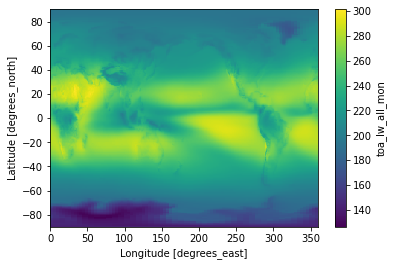

In [9]:
ceres_ds['toa_lw_all_mon'].mean('time').plot()

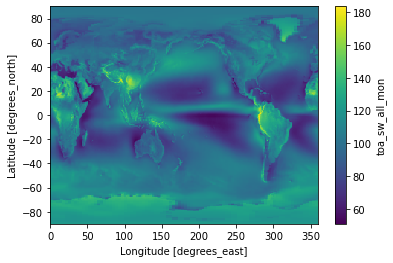

In [10]:
ceres_ds['toa_sw_all_mon'].mean('time').plot()

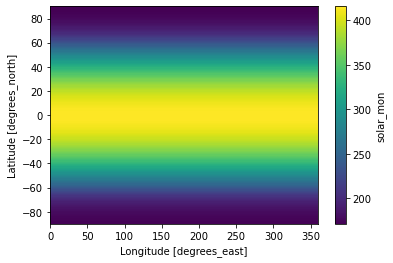

In [11]:
ceres_ds['solar_mon'].mean('time').plot()

In [ ]:
OSR=ds.toa_sw_all_mon.mean('time') ### outgoing solar radiation, measured by CERES
SOLIN=ds.solar_mon.mean('time')    ### incoming solar radiation, from the sun
ASR=SOLIN-OSR  ### sign convention, positive down.  incoming solar radiation minus outgoing solar radiation